In [102]:
import os
import pandas as pd
import env
import pandas as pd
import numpy as np

from env import user, password, host

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

In [126]:
database_url_base = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/'


def get_zillow_data(use_cache=True):
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cached csv')
        df = pd.read_csv('zillow.csv')
        df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'squarefeet',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built'})
        return df
    
    
    print('Acquiring data from SQL database')
    query = '''
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017

    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")

    '''
    df = pd.read_sql(query, database_url_base + 'zillow')
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'squarefeet',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built'})
    df.to_csv('zillow.csv', index=False)
   
    return df

In [127]:
df = get_zillow_data()
#first is to acciqure the data

Using cached csv


In [128]:
# take a look at the dataset head()
df.head(4)

,bedrooms,bathrooms,squarefeet,tax_value,year_built,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0


In [129]:
#Take a look at the shape of this data, how many columns and rows do this dataset contains. 
df.shape

(2152864, 7)

In [130]:
df.isnull().sum()

bedrooms        11
bathrooms       11
squarefeet    8485
tax_value      493
year_built    9338
taxamount     4442
fips             0
dtype: int64

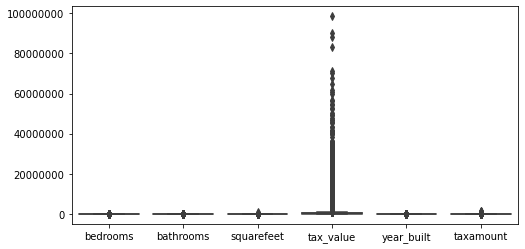

In [131]:
# Plot all the columns that we have here. black dots are outliners. 

plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['fips']))

plt.show()

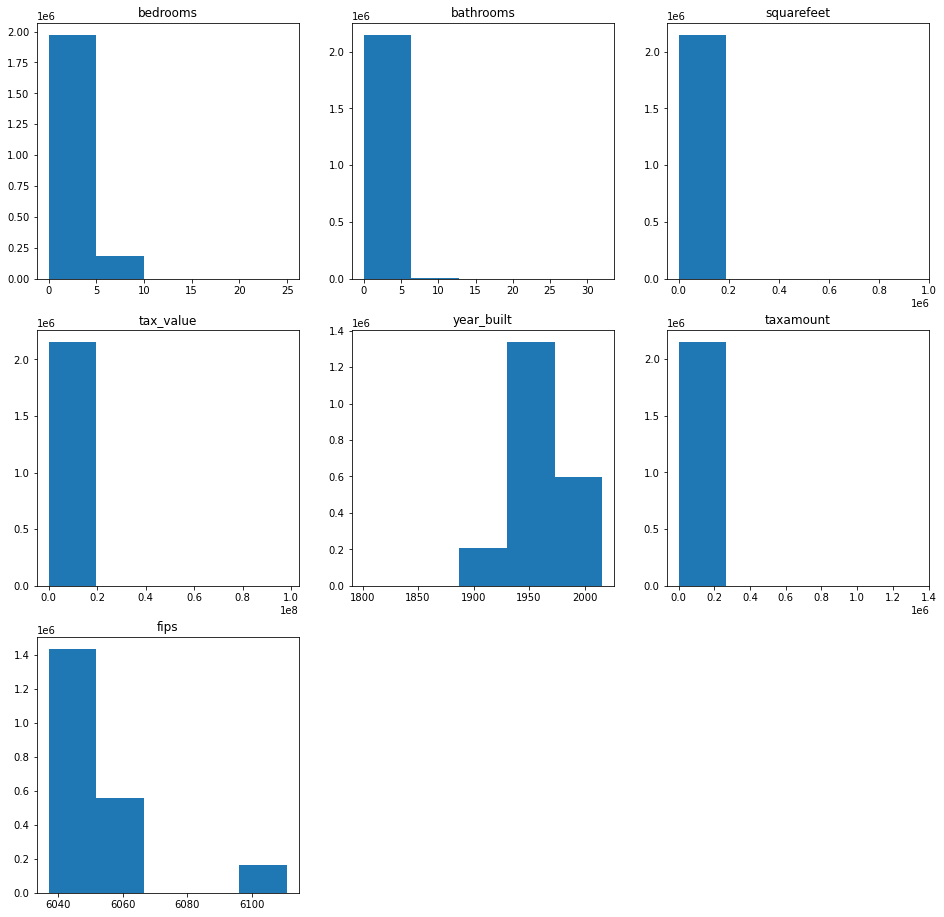

In [132]:
plt.figure(figsize=(16, 16))

for i, col in enumerate(df):
    plot_num = i+1
    plt.subplot(3,3,plot_num)
    plt.title(col)
    df[col].hist(bins=5)
    plt.grid(False)
plt.show()
    

In [133]:
df['tax_value'].head(5)

0     27516.0
1        10.0
2        10.0
3      2108.0
4    296425.0
Name: tax_value, dtype: float64

In [134]:
df['tax_value'].mean()

461896.0523613262

<AxesSubplot:>

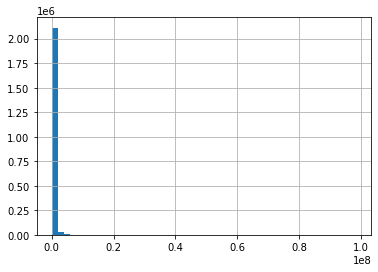

In [135]:
df['tax_value'].hist(bins = 50)

Takeaways: 
    The tax_values seems have a lot of outliners, remove these outliers maybe better.This study is not about outliers, I would like to spend more time research on the median or mean home, so I will find drop the outliers.  
    

In [136]:
q1, q3 = df['bedrooms'].quantile([0.25,0.75])

In [137]:
iqr = q3-q1
iqr

1.0

In [157]:
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

In [158]:
lower_bound

1.5

In [152]:
upper_bound

5.5

In [141]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [142]:
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'squarefeet', 'tax_value', 'taxamount'])
df

,bedrooms,bathrooms,squarefeet,tax_value,year_built,taxamount,fips
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
18,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037.0
19,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037.0
20,3.0,2.0,1222.0,290492.0,1951.0,3870.25,6037.0
...,...,...,...,...,...,...,...
2152853,3.0,2.0,1917.0,408680.0,1946.0,4341.32,6111.0
2152854,4.0,2.0,1987.0,259913.0,1955.0,3175.66,6059.0
2152856,3.0,2.5,1809.0,405547.0,2012.0,4181.10,6059.0
2152862,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


In [143]:
df.isnull().sum()

bedrooms        0
bathrooms       0
squarefeet      0
tax_value       0
year_built    874
taxamount       0
fips            0
dtype: int64

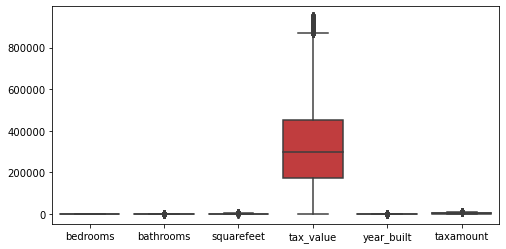

In [144]:
# Plot all the columns that we have here. black dots are outliners. 
# After drop the outliers, we have decrease our null values.
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['fips']))

plt.show()

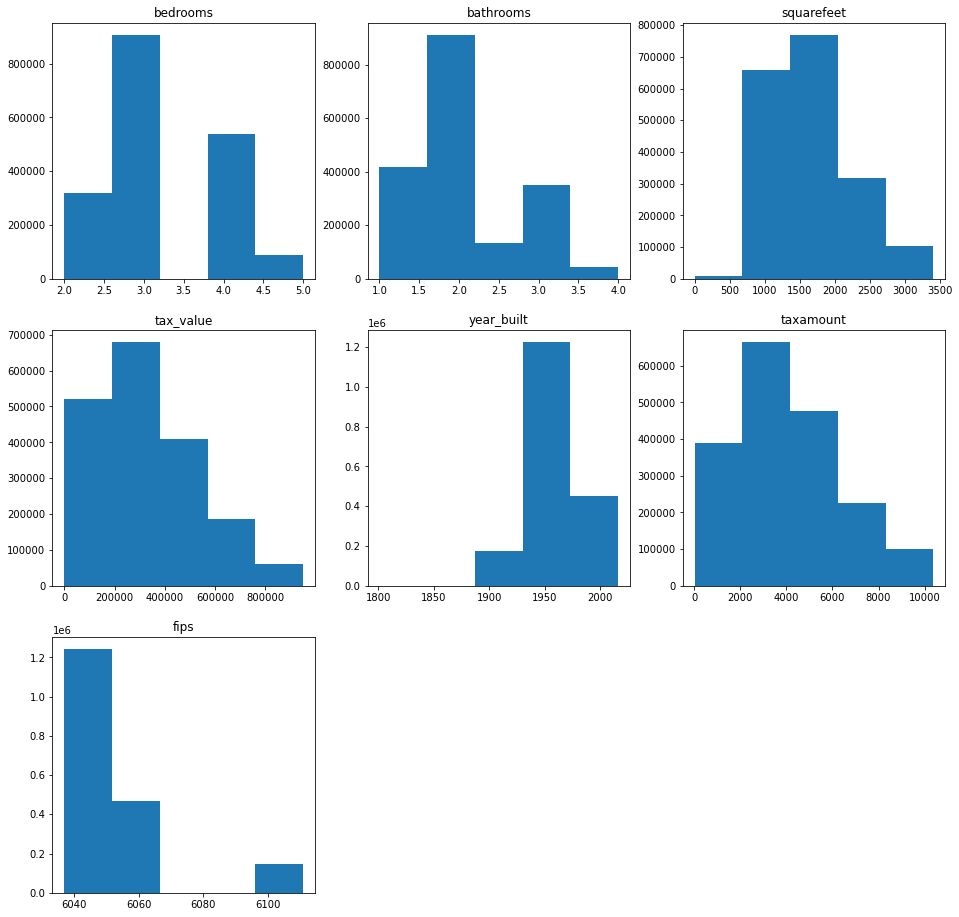

In [145]:
plt.figure(figsize=(16, 16))

for i, col in enumerate(df):
    plot_num = i+1
    plt.subplot(3,3,plot_num)
    plt.title(col)
    df[col].hist(bins=5)
    plt.grid(False)
plt.show()
    

# Next: 
I will drop the null conlumn since there are only 874 null values in year built. 

In [147]:
df.shape

(1855285, 7)

In [148]:
df.dropna(inplace=True)
df.shape

(1854411, 7)

In [149]:
df.isnull().sum()

bedrooms      0
bathrooms     0
squarefeet    0
tax_value     0
year_built    0
taxamount     0
fips          0
dtype: int64